<a href="https://colab.research.google.com/github/Dominickstephens/aLoRa/blob/QLora/Roberta_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries (PEFT is the modern standard for LoRA)
!pip install transformers datasets accelerate evaluate
!pip install -U peft
!pip install -U bitsandbytes
!pip show peft transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 42.7 MB/s eta 0:00:00
Name: peft
Version: 0.17.1
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: benjamin@huggingface.co
License: Apache
Location: /usr/local/lib/python3.12/dist-packages
Requires: accelerate, huggingface_hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 
---
Name: transformers
Version: 4.57.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.12/dist-packages
Requires: filelock, h

In [23]:
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType, AdaLoraConfig
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch
import numpy as np
import evaluate
import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt



# Configuration
MODEL_NAME = "roberta-base"
NUM_LABELS = 28
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 3
LEARNING_RATE = 5e-5
FF_LEARNING_RATE = 1e-5
BATCH_SIZE = 16
# https://arxiv.org/pdf/2412.12148
THRESHOLD = 0.5

In [3]:
# Load the dataset
ds = load_dataset("google-research-datasets/go_emotions", "simplified")

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
max_length = 128

def tokenize(batch):
    encodings = tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_length)
    encodings['labels'] = batch['labels']
    return encodings

ds_encoded = ds.map(tokenize, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])

    labels = []
    for item in batch:
        multi_hot = torch.zeros(NUM_LABELS, dtype=torch.float)
        if item['labels'] is not None:
            for l in item['labels']:
                if 0 <= l < NUM_LABELS:
                    multi_hot[l] = 1.0
        labels.append(multi_hot)

    labels = torch.stack(labels)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# Data Loaders
train_loader = DataLoader(ds_encoded['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ds_encoded['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Evaluation Metric
f1_metric = evaluate.load("f1", config="multilabel")

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [12]:
def prepare_model(method: str):
    """
    Prepares a RoBERTa model for fine-tuning using different PEFT strategies:
    - "Full"      : full fine-tuning
    - "LoRA"      : standard LoRA
    - "LoRA+"     : LoRA with Rescaled Stable adaptation
    - "AdaLoRA"   : Adaptive LoRA (dynamic rank allocation)
    - "DoRA"      : Weight-decomposed LoRA (Meta 2024)
    - "QLoRA"     : 4-bit quantized LoRA
    """

    # ---------- Optional quantization ----------
    quantization_config = None
    if method == "QLoRA":
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )

    # ---------- Load base RoBERTa ----------
    model = RobertaForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification",
        quantization_config=quantization_config,
        device_map="auto" if method == "QLoRA" else None,
    )

    # ---------- Choose PEFT variant ----------
    if method == "LoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
        )
        model = get_peft_model(model, config)
        print("\n🧩 Using LoRA")

    elif method == "LoRA+":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
            use_rslora=True,  # LoRA+
        )
        model = get_peft_model(model, config)
        print("\n⚙️ Using LoRA+")

    elif method == "AdaLoRA":
        config = AdaLoraConfig(
            task_type=TaskType.SEQ_CLS,
            init_r=8,
            target_r=4,
            tinit=100,
            tfinal=500,
            deltaT=10,
            lora_alpha=32,
            lora_dropout=0.1,
            total_step=len(train_loader) * EPOCHS
        )
        model = get_peft_model(model, config)
        print("\n🚀 Using AdaLoRA")

    elif method == "DoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query", "value"],
            use_dora=True,  # enables DoRA
        )
        model = get_peft_model(model, config)
        print("\n🧠 Using DoRA")

    elif method == "QLoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
        )
        model = get_peft_model(model, config)
        print("\n💾 Using QLoRA (4-bit quantized + LoRA)")

    else:
        print("\n🧱 Full Fine-Tuning (no adapters)")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total Parameters: {total_params / 1e6:.2f}M")
        print(f"Trainable Parameters: {trainable_params / 1e6:.2f}M (100%)")
        model.to(DEVICE)
        optimizer = AdamW(model.parameters(), lr=FF_LEARNING_RATE)
        return model, optimizer

    # ---------- Shared setup for PEFT variants ----------
    model.print_trainable_parameters()
    model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    return model, optimizer


In [8]:
def train_model(model, optimizer, method: str, train_loader, device, epochs, save_model):
    results = {}
    start_time = time.time()

    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True, desc=f"{method} Epoch {epoch+1}")
        for batch in loop:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

    total_train_time = time.time() - start_time
    results['train_time_sec'] = total_train_time

    cpt_str = method + "_checkpoint.pth"

    if save_model:
      torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      }, cpt_str)

    return model, results

In [9]:
def evaluate_model(model, val_loader, f1_metric, threshold, device, method: str):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            pred_probs = torch.sigmoid(logits)
            pred_labels = (pred_probs > threshold).long()

            all_preds.append(pred_labels.cpu().numpy())
            all_targets.append(labels.long().cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    f1_results = {"f1": f1_score(targets, preds, average="macro")}
    exact_match = np.mean([np.all(p == t) for p, t in zip(preds, targets)])

    results = {
        'f1_macro': f1_results['f1'],
        'exact_match_accuracy': exact_match
    }

    print("-" * 50)
    print(f"| {method} Evaluation Results |")
    print("-" * 50)
    print(f"Validation Macro F1 Score: {results['f1_macro']:.4f}")
    print(f"Validation Exact Match Accuracy: {results['exact_match_accuracy']:.4f}")
    print("-" * 50)

    return results

In [10]:
def cleanup(full_model=None, full_optimizer=None):
    if full_model is not None:
        del full_model
    if full_optimizer is not None:
        del full_optimizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [15]:
# results_table = []

print("Before FINE-TUNING")
print("="*60)
full_model, full_optimizer = prepare_model("Full Fine-Tuning")

# Evaluate
print("\nEvaluating model before training...")
pretrain_eval = evaluate_model(
    full_model,
    val_loader,
    f1_metric,
    THRESHOLD,
    DEVICE,
    "Full Fine-Tuning (Before Training)"
)

before_results = {"train_time_sec": 0.0, **pretrain_eval}
results_table.append({"Method": "Before Training", **before_results})

cleanup(full_model, full_optimizer)


Before FINE-TUNING


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧱 Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)

Evaluating model before training...
--------------------------------------------------
| Full Fine-Tuning (Before Training) Evaluation Results |
--------------------------------------------------
Validation Macro F1 Score: 0.0588
Validation Exact Match Accuracy: 0.0000
--------------------------------------------------


In [16]:
full_method = "Full Fine-Tuning"

full_model, full_optimizer = prepare_model(full_method)

train_full_model = True

if (train_full_model):
  # Train
  full_model, full_train_results = train_model(
      full_model,
      full_optimizer,
      full_method,
      train_loader,
      DEVICE,
      EPOCHS,
      save_model=True
  )
else:
  # Load checkpoint
  cpt_string = full_method + "_checkpoint.pth"
  checkpoint = torch.load(cpt_string)
  full_model.load_state_dict(checkpoint['model_state_dict'])
  full_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  results = {}
  results['train_time_sec'] = 0



# Evaluate
full_eval_results = evaluate_model(
    full_model,
    val_loader,
    f1_metric,
    THRESHOLD,
    DEVICE,
    full_method
)

full_results = {**full_train_results, **full_eval_results}
results_table.append({"Method": "Full Fine-Tuning", **full_results})

cleanup(full_model, full_optimizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧱 Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)


Full Fine-Tuning Epoch 3: 100%|██████████| 2714/2714 [03:51<00:00, 11.74it/s, loss=0.0514]


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
Validation Macro F1 Score: 0.4124
Validation Exact Match Accuracy: 0.4626
--------------------------------------------------


In [13]:
# ============================================================
# MULTI-RUN LoRA / QLoRA / AdaLoRA / DoRA BENCHMARK
# ============================================================
import torch

methods_to_run = ["LoRA", "LoRA+", "AdaLoRA", "DoRA"]
# results_table = []

for lora_method in methods_to_run:
    print("\n" + "="*70)
    print(f"🚀 Starting Fine-Tuning with {lora_method}")
    print("="*70)

    train_lora_model = True

    # ---- Prepare model and optimizer ----
    try:
        lora_model, lora_optimizer = prepare_model(lora_method)
    except Exception as e:
        print(f"❌ Failed to prepare {lora_method}: {e}")
        continue

    if train_lora_model:
        # ---- Train ----
        try:
            lora_model, lora_train_results = train_model(
                lora_model,
                lora_optimizer,
                lora_method,
                train_loader,
                DEVICE,
                EPOCHS,
                save_model=True
            )
        except torch.cuda.OutOfMemoryError:
            print(f"⚠️ Skipping {lora_method} (Out of memory)")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"❌ Training failed for {lora_method}: {e}")
            continue

    else:
        # ---- Load checkpoint ----
        cpt_string = f"{lora_method}_checkpoint.pth"
        checkpoint = torch.load(cpt_string)
        lora_model.load_state_dict(checkpoint["model_state_dict"])
        lora_optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        loss = checkpoint["loss"]
        lora_train_results = {"train_time_sec": 0, "final_loss": loss}

    # ---- Evaluate ----
    try:
        lora_eval_results = evaluate_model(
            lora_model,
            val_loader,
            f1_metric,
            THRESHOLD,
            DEVICE,
            lora_method
        )
    except Exception as e:
        print(f"❌ Evaluation failed for {lora_method}: {e}")
        continue

    # ---- Merge and store results ----
    lora_results = {**lora_train_results, **lora_eval_results}
    results_table.append({"Method": lora_method, **lora_results})

    # ---- Cleanup GPU memory ----
    del lora_model
    del lora_optimizer
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("🏁 ALL EXPERIMENTS COMPLETE")
print("="*70)

# Convert to DataFrame for nice display (optional)
import pandas as pd
results_df = pd.DataFrame(results_table)
display(results_df)



🚀 Starting Fine-Tuning with AdaLoRA


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Using AdaLoRA
trainable params: 1,939,804 || all params: 126,607,040 || trainable%: 1.5321


AdaLoRA Epoch 3: 100%|██████████| 2714/2714 [05:53<00:00,  7.68it/s, loss=0.138]


--------------------------------------------------
| AdaLoRA Evaluation Results |
--------------------------------------------------
Validation Macro F1 Score: 0.4003
Validation Exact Match Accuracy: 0.4060
--------------------------------------------------

🏁 ALL EXPERIMENTS COMPLETE


,Method,train_time_sec,f1_macro,exact_match_accuracy
0,LoRA,471.309408,0.396423,0.414854
1,LoRA+,472.351879,0.398425,0.418356
2,DoRA,565.154029,0.405193,0.408588
3,AdaLoRA,1055.078110,0.400287,0.406008


In [17]:
results_print = {}

for result in results_table:
    method_name = result["Method"]
    model = prepare_model(method_name)[0]
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    train_time = result.get("train_time_sec", 0.0)
    f1_macro = result.get("f1_macro", 0.0)

    results_print[method_name] = [trainable_params/1e6, train_time, f1_macro]

print("\n\nCOMPARISON OF RESULTS")
print("#"*60)

print(f"| {'Method':<20} | {'Trainable Params (M)':<20} | {'Train Time (s)':<15} | {'Macro F1':<10} |")
print("-" * 75)

for key, value in results_print.items():
    print(f"|{key:<20}|", end = " ")
    for x in value:
      print(f"{x:20.4f}", end = " ")
    print("\n")

# print(f"| {method_name:<20} | {trainable_params/1e6:<20.2f}M | {train_time:<15.2f} | {f1_macro:<10.4f} |")

print("#" * 60)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧩 Using LoRA
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



⚙️ Using LoRA+
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧠 Using DoRA
trainable params: 925,468 || all params: 125,592,632 || trainable%: 0.7369


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Using AdaLoRA
trainable params: 1,939,804 || all params: 126,607,040 || trainable%: 1.5321


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧱 Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🧱 Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)


COMPARISON OF RESULTS
############################################################
| Method               | Trainable Params (M) | Train Time (s)  | Macro F1   |
---------------------------------------------------------------------------
|LoRA                |               0.9070             471.3094               0.3964 

|LoRA+               |               0.9070             472.3519               0.3984 

|DoRA                |               0.9255             565.1540               0.4052 

|AdaLoRA             |               1.9398            1055.0781               0.4003 

|Before Training     |             124.6672               0.0000               0.0588 

|Full Fine-Tuning    |             124.6672             694.5851               0.4124 

############################################################


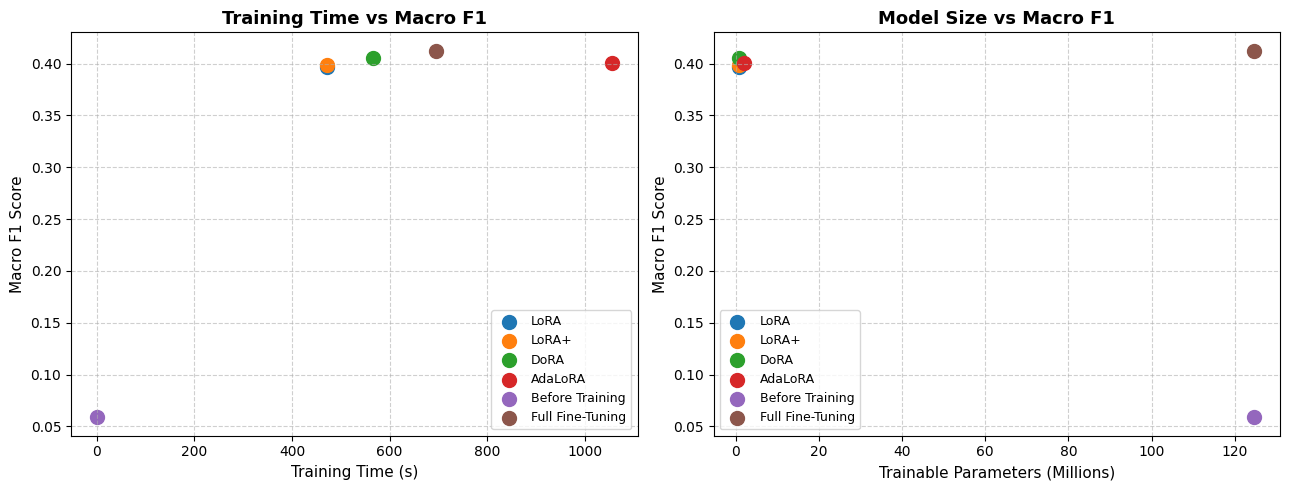

In [24]:
methods = list(results_print.keys())
params = [v[0] for v in results_print.values()]
train_times = [v[1] for v in results_print.values()]
f1_macros = [v[2] for v in results_print.values()]

plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
for i, method in enumerate(methods):
    plt.scatter(train_times[i], f1_macros[i], s=100, label=method)
plt.xlabel('Training Time (s)', fontsize=11)
plt.ylabel('Macro F1 Score', fontsize=11)
plt.title('Training Time vs Macro F1', fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9, loc='lower right')

plt.subplot(1, 2, 2)
for i, method in enumerate(methods):
    plt.scatter(params[i], f1_macros[i], s=100, label=method)
plt.xlabel('Trainable Parameters (Millions)', fontsize=11)
plt.ylabel('Macro F1 Score', fontsize=11)
plt.title('Model Size vs Macro F1', fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=9, loc='lower left')

plt.tight_layout()
plt.show()
